<a href="https://colab.research.google.com/github/kioneta/API/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22sqlite_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Создание Базы данных

In [ ]:
import sqlite3
import csv
import os

In [ ]:
db = sqlite3.connect('t_orders.db') # создаю базу данных с нужным разрешением

In [ ]:
c = db.cursor() # создаем курсор

In [ ]:
#создаем таблицу с соответствующими полями
c.execute("""CREATE TABLE t_orders (
                                    organization_id integer,
                                    sales_order integer,
                                    date_create datetime,
                                    status integer,
                                    code integer,
                                    client_id integer,
                                    tvz_id integer,
                                    cost_price float,
                                    price_b2b_gross float,
                                    price_b2c_gross float,
                                    quantity integer
                                    )


          """)

In [ ]:
db.commit()

In [ ]:
#вставляем данный из подготовленного csv файла
with open('t_orders.csv', 'r') as f_open_csv:
      rows = csv.reader(f_open_csv, delimiter=",")

      for row in rows:
          c.execute('INSERT INTO t_orders VALUES (?, ?, ?, ?, ?,?, ?, ?, ?, ?, ?)', row)

In [ ]:
#добавляю столбец id. Возможно понадобиться позже например для джойнов и т.д.
c.execute("""ALTER TABLE t_orders ADD COLUMN id INTEGER""")
c.execute("""UPDATE t_orders SET id = rowid""")

In [ ]:
#Смотрю первые 20 записей
c.execute('SELECT * FROM t_orders')
print(c.fetchmany(20))

[(13, 2051016936, '2022-06-01T07:01:02.473', 0, 48747, 13183, 7233, 347.11, 469.18, 504.36, 1, 1), (2, 2051016937, '2022-06-01T07:12:02.541', 0, 44320, 7519, 2592, 108.55, 155.39, 167.04, 2, 2), (13, 2051016938, '2022-06-01T07:43:02.496', 0, 54462, 1558, 7149, 401.17, 447.12, 480.65, 2, 3), (1, 2051016939, '2022-06-01T07:53:02.430', 0, 58963, 30244, 1232, 413.28, 496.25, 533.46, 2, 4), (1, 2051016940, '2022-06-01T07:53:02.744', 0, 304, 5112, 372, 168.15, 198.42, 228.47, 2, 5), (1, 2051016941, '2022-06-01T08:14:02.351', 0, 40693, 63084, 1280, 196.73, 230.5, 247.87, 2, 6), (5, 2051016942, '2022-06-01T08:14:02.830', 0, 66585, 19055, 3298, 352.62, 444.17, 475.27, 3, 7), (5, 2051016942, '2022-06-01T08:14:02.830', 0, 65446, 19055, 3298, 515.66, 598.44, 655.24, 1, 8), (1, 2051016943, '2022-06-01T08:14:03.232', 1, 9372, 55499, 1010, 22.17, 24.38, 32.33, 2, 9), (1, 2051016943, '2022-06-01T08:14:03.232', 1, 4355, 55499, 1010, 40.33, 52.38, 56.04, 3, 10), (1, 2051016944, '2022-06-01T08:47:02.829'

In [ ]:
#проверяю все ли данные были выгружены
c.execute('SELECT COUNT(*) FROM t_orders')
print(c.fetchmany(20))

[(27704,)]


#Задание 1
Рассчитать маржу в рублях и % по всей компании в разрезе месяцев \
Вывести: Месяц, Маржа руб., Маржа % \
Предоставить запрос в SQL.

In [ ]:
#вывожу месяц, суммирую маржу и округляю до 2х знаков после запятой, нахожу ср значение маржи в %
#фильтрую по статусу, только выданные заказы. Группирую по месяцу, сортирую по месяцу

c.execute("""SELECT strftime('%m', date_create) as month,
                    round(SUM(price_b2c_gross - cost_price), 2) as margin_rub,
                    AVG((price_b2c_gross - cost_price)/price_b2c_gross)*100 as margin_percentage
          FROM t_orders
          WHERE status = 0
          GROUP BY month
          ORDER BY month

          """)
list = c.fetchall()
list

[('06', 1390342.75, 27.83157082692698),
 ('07', 1233548.47, 27.529687508331325),
 ('08', 1581203.69, 27.79825291459876)]

In [ ]:
#вывожу результаты в более читабельном виде
print("month", "margin_rub", "margin_percentage")
for i in list:
  print(i)

month margin_rub margin_percentage
('06', 1390342.75, 27.83157082692698)
('07', 1233548.47, 27.529687508331325)
('08', 1581203.69, 27.79825291459876)


#Задание 2
Выбрать топ 5 самых прибыльных позиций в разрезе каждого РК, за весь период. \
Предоставить запрос в SQL.

In [ ]:
#Предположу, что РК это регион.
#Вначе делаю подзапрос, чтобы пронумировать позиции в рамках региона начиная от самых прибыльных до менее прибыльных.
#Вывожу поля:регион, позицию по прибыльности, код товара и маржу.
#Только топ 5.
c.execute("""SELECT organization_id, row_num, code, ROUND(margin,2)
          FROM (
            SELECT (price_b2c_gross - cost_price) as margin, code, organization_id,
                    ROW_NUMBER() OVER (PARTITION BY organization_id ORDER BY (price_b2c_gross - cost_price) DESC) AS row_num
            FROM t_orders
            WHERE status = 0
          ) AS subquery
          WHERE row_num <= 5


          """)
list2 = c.fetchall()
list2


[(1, 1, 1842, 5454.39),
 (1, 2, 57758, 5172.17),
 (1, 3, 52092, 3558.57),
 (1, 4, 57759, 3338.2),
 (1, 5, 60272, 3315.0),
 (2, 1, 64255, 4352.61),
 (2, 2, 42746, 3192.75),
 (2, 3, 1840, 2460.39),
 (2, 4, 1840, 2460.39),
 (2, 5, 1840, 2305.2),
 (4, 1, 66020, 693.51),
 (4, 2, 45041, 337.31),
 (4, 3, 20287, 315.36),
 (4, 4, 59982, 314.31),
 (4, 5, 55801, 302.19),
 (5, 1, 57759, 5586.28),
 (5, 2, 64255, 4459.3),
 (5, 3, 26762, 3866.06),
 (5, 4, 57759, 3207.8),
 (5, 5, 57759, 3207.8),
 (6, 1, 64957, 2209.28),
 (6, 2, 17692, 2029.99),
 (6, 3, 65891, 1138.82),
 (6, 4, 53888, 661.39),
 (6, 5, 51449, 526.3),
 (7, 1, 53792, 3401.75),
 (7, 2, 42040, 2233.15),
 (7, 3, 49536, 1805.75),
 (7, 4, 58938, 1607.93),
 (7, 5, 43654, 1559.16),
 (8, 1, 1842, 7066.63),
 (8, 2, 64255, 4436.67),
 (8, 3, 57758, 3553.47),
 (8, 4, 1840, 1994.82),
 (8, 5, 11268, 1416.26),
 (9, 1, 53792, 3194.83),
 (9, 2, 57596, 1667.02),
 (9, 3, 43654, 1318.84),
 (9, 4, 65887, 1017.93),
 (9, 5, 46520, 1012.98),
 (10, 1, 61398, 609.

#Задание 3
В какой день недели клиенты чаще делают покупки. Проанализировать август. \
Вывести: День недели, Среднее количество заказов в этот день \
Предоставить запрос в SQL + ответ.
#Ответ - вт


In [ ]:
#Заметка по дням неделям: 0 -вс, 1 - пн  и т.д.
# Вначале создаю подзапрос, где мы считаем в рамках одного дня количество заказов.
# Потом агрегирую количество заказов по дню недели, и сортирую по убыванию.
# Вывожу первое значение
c.execute("""SELECT strftime('%w', date) as day_of_week, AVG(sales_order_N) as AVG_orders_N

            FROM (SELECT 	strftime('%Y-%m-%d',date_create) as date, COUNT(sales_order) as sales_order_N
                  FROM t_orders
                  WHERE strftime('%m', date_create) = '06'
                  GROUP BY strftime('%Y-%m-%d',date_create)
                  )

            GROUP BY day_of_week
            ORDER BY AVG_orders_N DESC
            LIMIT 1
          """)
list3 = c.fetchall()
list3

[('2', 411.75)]

#Задание 4
Построить динамику доли выкупа заказов по их суммам в разрезе недель за июль. \
Предоставить запрос в SQL + нарисовать диаграмму в Redash или Excel.

In [ ]:
#Суммирую заказы, которые были выкуплены (Статус = '0') и делю эту сумму на общую сумму всех заказов в каждой неделе, чтобы рассчитать долю выкупленных заказов
#Затем результаты группирую по номеру недели и вывожу динамику доли выкупа заказов по их суммам в разрезе недель за июль.

c.execute("""SELECT strftime('%W', date_create) as week,
                    SUM(CASE WHEN status = 0 THEN price_b2c_gross ELSE 0 END) / SUM(price_b2c_gross) AS doly
          FROM t_orders
          WHERE strftime('%m', date_create) = '07'
          GROUP BY week

          """)
list4 = c.fetchall()
list4

[('26', 0.8632211722462044),
 ('27', 0.8963230347835637),
 ('28', 0.8747953289879444),
 ('29', 0.7871001920016769),
 ('30', 0.8680276495325684)]

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# Отделяю столбец с неделями и столбец с долями
x = []
y = []
for i in range(len(list4)):
  x.append(list4[i][0])
  y.append(list4[i][1])

[0.8632211722462044,
 0.8963230347835637,
 0.8747953289879444,
 0.7871001920016769,
 0.8680276495325684]

Text(0, 0.5, 'rate')

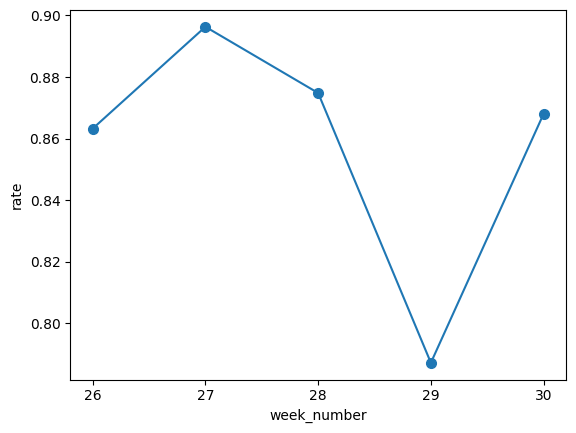

In [ ]:
#строю график
plt.plot(x, y, marker='o', markersize=7)
plt.xlabel("week_number")
plt.ylabel("rate")

Text(0, 0.5, 'rate')

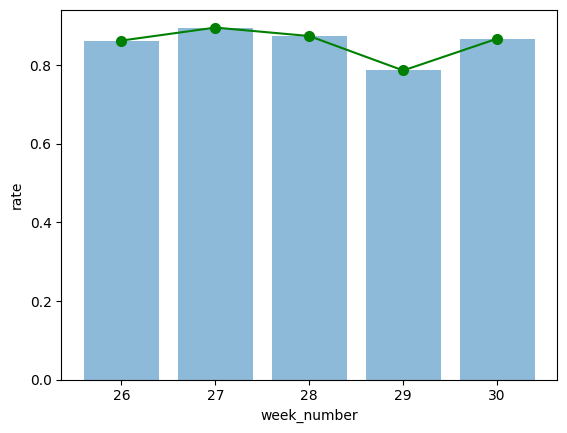

In [ ]:
#строю график2
plt.bar(x, y, alpha=0.5)
plt.plot(x, y, color='green', marker='o', markersize=7)
plt.xlabel("week_number")
plt.ylabel("rate")

#Задание 5
Рассчитать за весь период товары, которые часто продаются друг с другом.\
Вывести: Первый товар, Сопутствующий товар, Количество чеков с данными товарами\
Предоставить запрос в SQL.


In [ ]:
#  Джойним таблицу саму на себя, чтобы добавить столбец товаров и перебрать все возможные комбинации сочетания товаров в рамках заказа.
#  t_orders_1.id < t_orders_2.id - исплючает дублирование пар
#  Выбираем только выданные заказы
#  Выводим только если пар было больше 4

c.execute("""SELECT t_orders_1.code as first_code,
                    t_orders_2.code as second_code,
                    COUNT(DISTINCT t_orders_1.sales_order) AS Check_count
          FROM t_orders t_orders_1
          JOIN t_orders t_orders_2 ON t_orders_1.sales_order = t_orders_2.sales_order
                                   AND t_orders_1.code < t_orders_2.code
          WHERE t_orders_1.status = 0
          GROUP BY t_orders_1.code, t_orders_2.code
          HAVING Check_count > 4
          ORDER BY Check_count DESC
          """)
list5 = c.fetchall()
list5

[(20362, 20363, 15),
 (20362, 20365, 13),
 (20363, 20365, 13),
 (20362, 20370, 12),
 (20362, 20364, 10),
 (20363, 20370, 10),
 (20368, 20370, 10),
 (18594, 20370, 9),
 (20362, 20389, 9),
 (20363, 20364, 8),
 (20364, 20365, 8),
 (20365, 20370, 8),
 (18594, 20362, 7),
 (18594, 20365, 7),
 (18594, 20368, 7),
 (20362, 20368, 7),
 (20362, 20380, 7),
 (20363, 20368, 7),
 (20364, 20370, 6),
 (20364, 20389, 6),
 (20370, 20389, 6),
 (38350, 38351, 6),
 (40697, 40698, 6),
 (67045, 67053, 6),
 (67045, 67068, 6),
 (10927, 61925, 5),
 (18594, 20363, 5),
 (18594, 20364, 5),
 (20363, 20389, 5),
 (20365, 20368, 5),
 (20365, 20389, 5),
 (22901, 38351, 5),
 (38351, 40012, 5)]

In [ ]:
#попытка решить другим путем

c.execute("""WITH Combinations AS (
                                    SELECT t_orders_1.code as first_code, t_orders_2.code as second_code, t_orders_1.sales_order
                                    FROM t_orders t_orders_1
                                    JOIN t_orders t_orders_2 ON t_orders_1.sales_order = t_orders_2.sales_order
                                                              AND t_orders_1.code < t_orders_2.code
                                     WHERE t_orders_1.status = 0
                                  )
              SELECT first_code, second_code, COUNT(DISTINCT sales_order) AS Check_count
              FROM Combinations
              GROUP BY first_code, second_code
              HAVING Check_count > 4
              ORDER BY Check_count DESC
          """)
list5 = c.fetchall()
list5

[(20362, 20363, 15),
 (20362, 20365, 13),
 (20363, 20365, 13),
 (20362, 20370, 12),
 (20362, 20364, 10),
 (20363, 20370, 10),
 (20368, 20370, 10),
 (18594, 20370, 9),
 (20362, 20389, 9),
 (20363, 20364, 8),
 (20364, 20365, 8),
 (20365, 20370, 8),
 (18594, 20362, 7),
 (18594, 20365, 7),
 (18594, 20368, 7),
 (20362, 20368, 7),
 (20362, 20380, 7),
 (20363, 20368, 7),
 (20364, 20370, 6),
 (20364, 20389, 6),
 (20370, 20389, 6),
 (38350, 38351, 6),
 (40697, 40698, 6),
 (67045, 67053, 6),
 (67045, 67068, 6),
 (10927, 61925, 5),
 (18594, 20363, 5),
 (18594, 20364, 5),
 (20363, 20389, 5),
 (20365, 20368, 5),
 (20365, 20389, 5),
 (22901, 38351, 5),
 (38351, 40012, 5)]

#Задание 6
Сформировать отчет в редаше с параметрами: Период, Тип отрезка. \
Период - просто выбирает временной период без времени, Тип отрезка - группирует данные по дню, неделе, месяцу, году. \
Предоставить запрос в SQL. (ниже)

In [ ]:
SELECT
    COUNT(*), DATE_TRUNC('{{Тип отрезка}}', date_create)
FROM
    t_orders
WHERE
    date_create >= '{{ Период.start }}'
    AND t_orders.date_create <= '{{ Период.end }}'
GROUP BY
    DATE_TRUNC('{{Тип отрезка}}', date_create)

Пример реализации на чужом датасете в Симуляторе Карпова.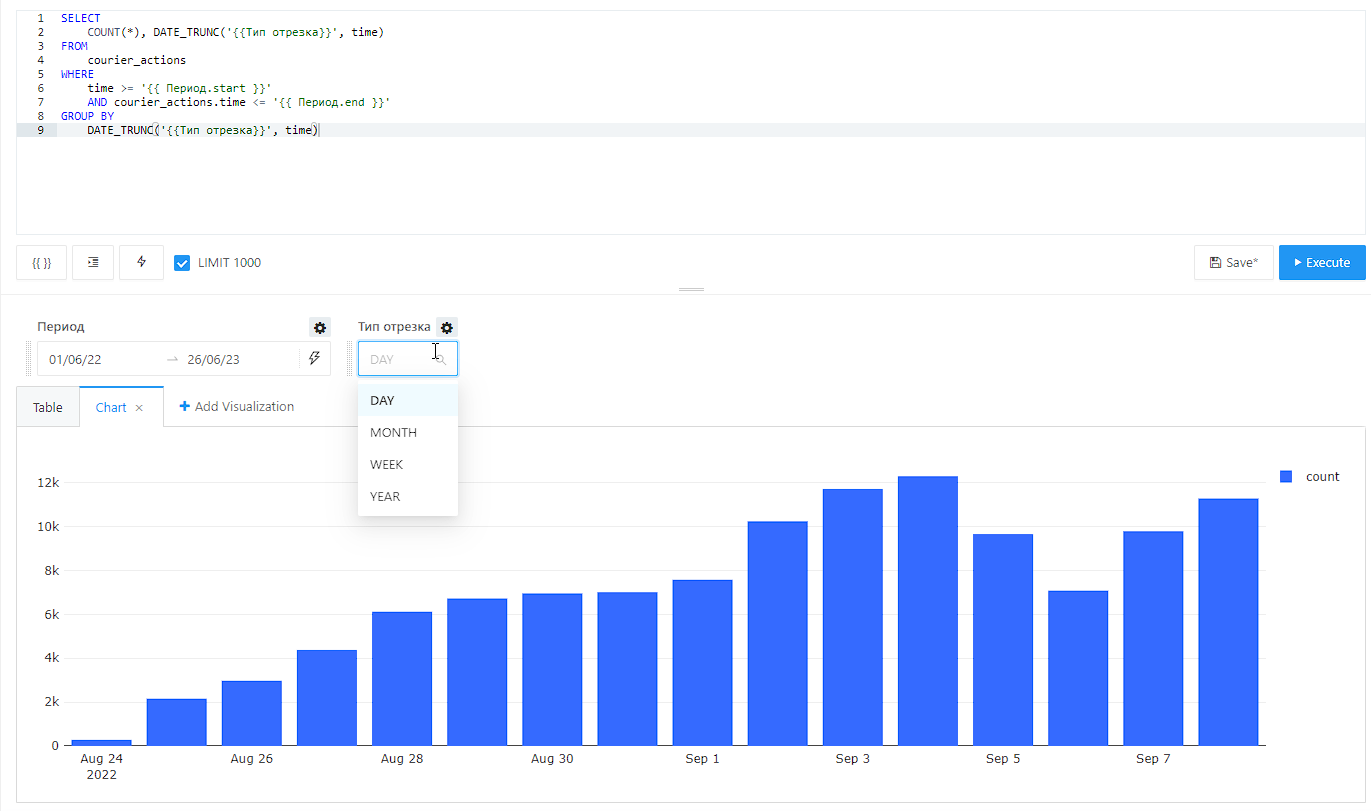

Изменение фильтра
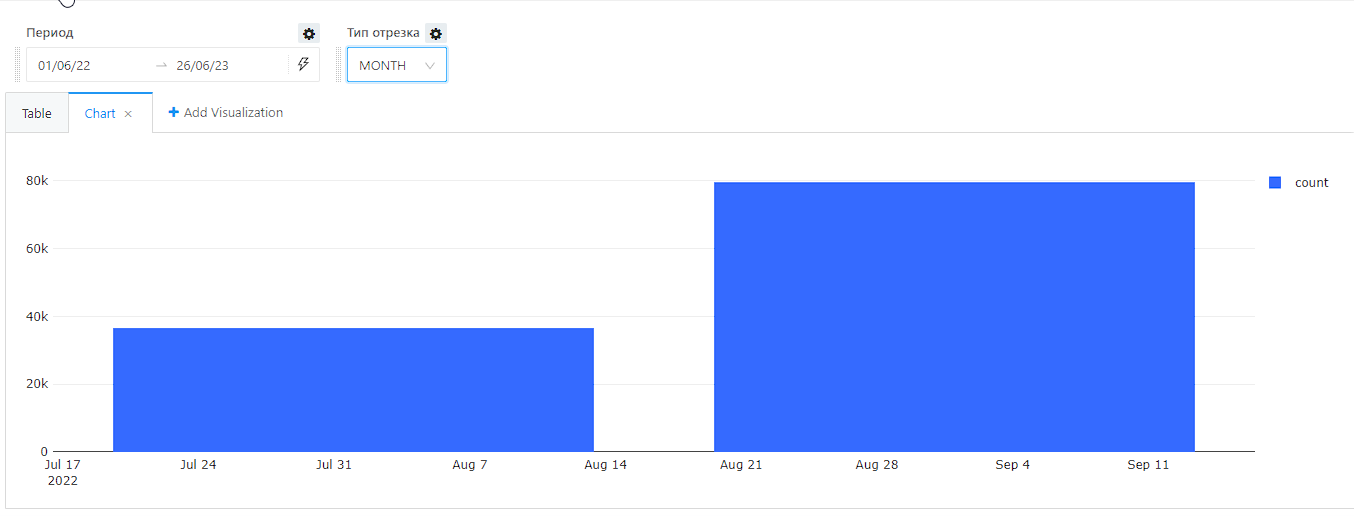

#Задание 7
Нужно распарсить и пронумеровать значения  в прямоугольных скобках в текущем порядке. \
Вывести 2 колонки: Порядковый номер, Значение. \
Предоставить решение в SQL и решение на Python\
[[174.0,103.0,77.0,42.0,54.0,81.0,140.0,235.0,438.0,557.0,688.0,708.0,669.0,612.0,688.0,675.0,933.0,1015.0,998.0,834.0,861.0,658.0,617.0,414.0]]

# Решение на python

In [ ]:
a = '[174.0,103.0,77.0,42.0,54.0,81.0,140.0,235.0,438.0,557.0,688.0,708.0,669.0,612.0,688.0,675.0,933.0,1015.0,998.0,834.0,861.0,658.0,617.0,414.0]'

In [ ]:
a = a.strip('[]') # убираем лишнии скобки

In [ ]:
a = a.split(',') # создаем список цифр разделенных элементом ","

In [ ]:
import pandas as pd

In [ ]:
# самый просто способ сделать через пандосовский датафрейм
df = pd.DataFrame(columns=['id', 'value'])

In [ ]:
# присваиваю значение колонкам
df['value'] = a
df['id'] = df['value'].index + 1

In [ ]:
# первые 5 строк
df.head()

,id,value
0,1,174.0
1,2,103.0
2,3,77.0
3,4,42.0
4,5,54.0


# Решение через SQL


In [ ]:
import sqlite3

In [ ]:
db = sqlite3.connect('task_7.db') # создаю базу данных с нужным разрешением
c = db.cursor() # создаем курсор

In [ ]:
#создаем таблицу с соответствующими полями
c.execute("""CREATE TABLE task7 (
                                'id' INT NOT NULL PRIMARY KEY AUTOINCREMENT,
                                'value' INT
                                )
          """)

In [ ]:
# значения
a = '[174.0,103.0,77.0,42.0,54.0,81.0,140.0,235.0,438.0,557.0,688.0,708.0,669.0,612.0,688.0,675.0,933.0,1015.0,998.0,834.0,861.0,658.0,617.0,414.0]'
a = a.strip('[]') # убираем лишнии скобки
a = a.split(',') # создаем список цифр разделенных элементом ","

In [ ]:
# вставляю данные
value = [(val,) for val in a]
c.executemany('INSERT INTO task7 (value) VALUES (?)', value)

In [ ]:
db.commit()

In [ ]:
#вывожу результат
c.execute('SELECT * FROM task7')
list = c.fetchall()
for i in list:
  print(i)

(1, 174)
(2, 103)
(3, 77)
(4, 42)
(5, 54)
(6, 81)
(7, 140)
(8, 235)
(9, 438)
(10, 557)
(11, 688)
(12, 708)
(13, 669)
(14, 612)
(15, 688)
(16, 675)
(17, 933)
(18, 1015)
(19, 998)
(20, 834)
(21, 861)
(22, 658)
(23, 617)
(24, 414)


In [ ]:
db.close